In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('emotion-classification-facial-keypoint-detection')
jovian.set_colab_id('1RwJd5exJB_UroNpkleZOonMGrjxpK0qz')

# Emotion Classification and Facial Keypoint Detection



## Import and Load the Data

In [ ]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od
import os
import zipfile
import tarfile

In [ ]:
dataset_url = 'https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data'

od.download(dataset_url)

  0%|          | 0.00/285M [00:00<?, ?B/s]

100%|██████████| 285M/285M [00:03<00:00, 85.8MB/s]

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd '/content/drive/My Drive/Machine Learning Project'

/content/drive/My Drive/Machine Learning Project


In [6]:
os.listdir()

['fer2013',
 'example_submission.csv',
 'fer2013.tar.gz',
 'icml_face_data.csv',
 'test.csv',
 'train.csv']

In [7]:
!tar xvzf 'Machine Learning Project/fer2013.tar.gz'

tar (child): Machine Learning Project/fer2013.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


## Imports and Data Exploration

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid

In [9]:
fer_df = pd.read_csv('fer2013/fer2013.csv')

In [10]:
fer_df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [11]:
len(fer_df['pixels'][20].split(' '))

2304

In [12]:
np.sqrt(2304)

48.0

Convert the pixels string to images of shape 48 x 48, then convert it to shape 96 x 96

In [13]:
fer_df['pixels'] = fer_df['pixels'].apply(lambda x: np.asarray(x.split(' '), dtype=np.float32).reshape(48, 48))

In [14]:
def Resize(img):
    return cv2.resize(img, dsize=(96,96), interpolation=cv2.INTER_CUBIC)

In [15]:
fer_df['pixels'] = fer_df['pixels'].apply(lambda x: Resize(x))

In [16]:
fer_df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [17]:
fer_df

,emotion,pixels,Usage
0,0,"[[69.316925, 73.03865, 79.13719, 84.17186, 85....",Training
1,0,"[[151.09435, 150.91393, 150.65791, 148.96367, ...",Training
2,2,"[[232.82552, 229.81886, 225.59953, 200.68909, ...",Training
3,4,"[[23.061905, 25.50914, 29.47847, 33.99843, 36....",Training
4,6,"[[4.771652, 3.3384705, 0.9779358, -0.45524597,...",Training
...,...,...,...
35882,6,"[[51.798325, 48.184937, 42.48755, 31.175934, 2...",PrivateTest
35883,3,"[[178.1166, 176.83118, 174.74146, 172.61276, 1...",PrivateTest
35884,0,"[[16.883408, 16.953583, 17.081573, 16.53476, 1...",PrivateTest
35885,3,"[[30.199814, 29.574478, 28.545822, 27.846603, ...",PrivateTest


In [35]:
label_to_text = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}

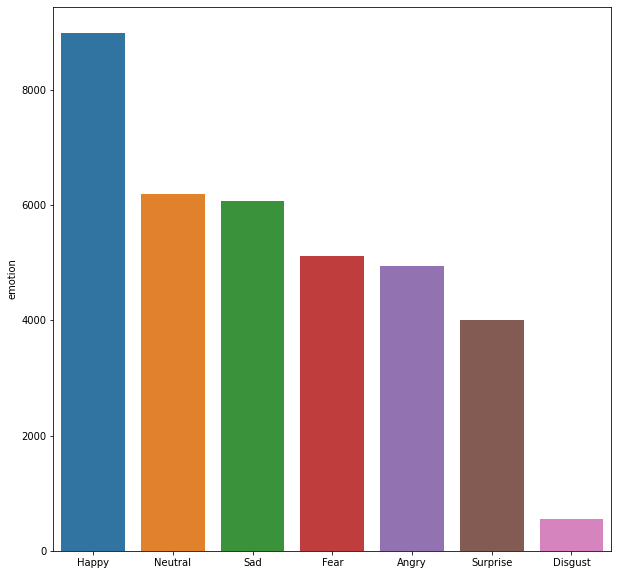

In [34]:
plt.figure(figsize = (10,10))
sns.barplot(x = list(map(lambda x: label_to_text[x],fer_df['emotion'].value_counts().index)), y = fer_df['emotion'].value_counts())

## Create Dataset

In [18]:
from torch.utils.data import TensorDataset

In [19]:
train_df = fer_df[fer_df['Usage'] == 'Training']
train_df.drop(['Usage'],axis=1,inplace=True)

test_df = fer_df[fer_df['Usage'] == 'PublicTest']
test_df.drop(['Usage'],axis=1,inplace=True)

valid_df = fer_df[fer_df['Usage'] == 'PrivateTest']
valid_df.drop(['Usage'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
train_df.shape, test_df.shape, valid_df.shape

((28709, 2), (3589, 2), (3589, 2))

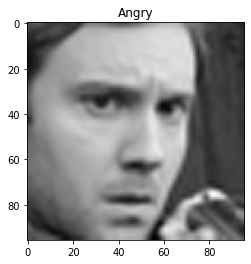

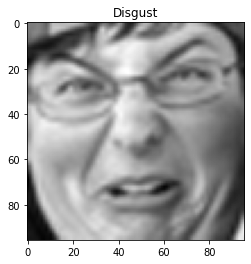

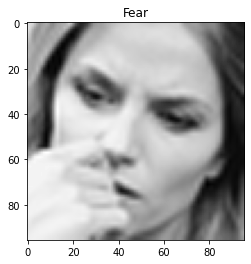

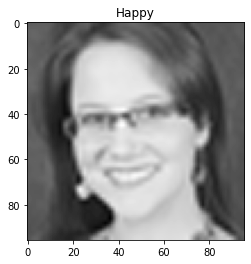

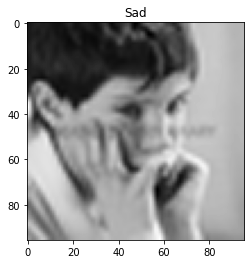

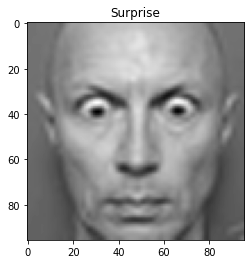

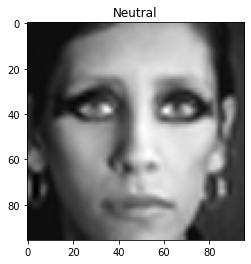

In [21]:
emotions = [0,1,2,3,4,5,6]

for i in emotions:
    img = train_df['pixels'][train_df['emotion'] == i][:1].item()
    plt.figure()
    plt.imshow(img, cmap='gray')
    # print(img.shape) 
    plt.title(label_to_text[i])

In [22]:
train_X = torch.tensor(train_df['pixels'].apply(lambda x : x.reshape(1, 96, 96)))
train_y = torch.tensor(train_df['emotion'])

In [23]:
train_X.shape, train_y.shape

(torch.Size([28709, 1, 96, 96]), torch.Size([28709]))

In [28]:
test_imgs = test_df['pixels'].values

test_X = np.empty((len(test_imgs), 1, 96, 96), dtype=np.float32)

for i in range(len(img)):
  test_X[i,] = np.expand_dims(img[i], axis = 0)
  
test_X = torch.tensor(test_X)
test_y = torch.tensor(test_df['emotion'].values)

In [29]:
test_X.shape, test_y.shape

(torch.Size([3589, 1, 96, 96]), torch.Size([3589]))

In [30]:
valid_imgs = valid_df['pixels'].values

valid_X = np.empty((len(valid_imgs), 1, 96, 96), dtype=np.float32)

for i in range(len(img)):
  valid_X[i,] = np.expand_dims(img[i], axis = 0)
  
valid_X = torch.tensor(valid_X)
valid_y = torch.tensor(valid_df['emotion'].values)

In [31]:
valid_X.shape, valid_y.shape

(torch.Size([3589, 1, 96, 96]), torch.Size([3589]))

### Create Datasets

In [32]:
train_ds = TensorDataset(train_X, train_y)
test_ds = TensorDataset(test_X, test_y)
valid_ds = TensorDataset(valid_X, valid_y)

In [36]:
from torch.utils.data import DataLoader

In [38]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=2, pin_memory=True)

In [39]:
for img, label in train_dl:
    print(img.shape)
    break

torch.Size([128, 1, 96, 96])


In [41]:
def show_batch(dl):
  for images, label in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
    break

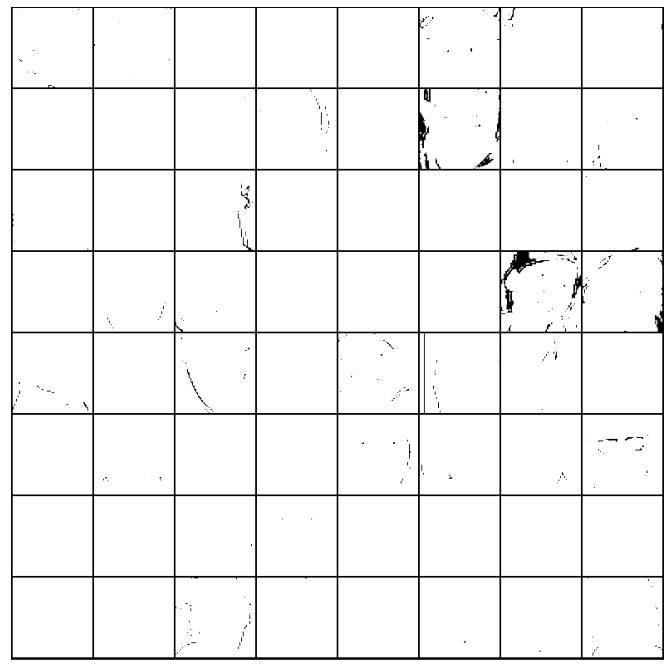

In [45]:
show_batch(train_dl)

# Update to Jovian

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="emotion-classification-facial-keypoint-detection")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/developer-jnk/emotion-classification-facial-keypoint-detection


'https://jovian.ai/developer-jnk/emotion-classification-facial-keypoint-detection'